### Case Study #1 - Danny's Diner

https://8weeksqlchallenge.com/case-study-1/



<h2> Entity Relationship Diagram </h2>

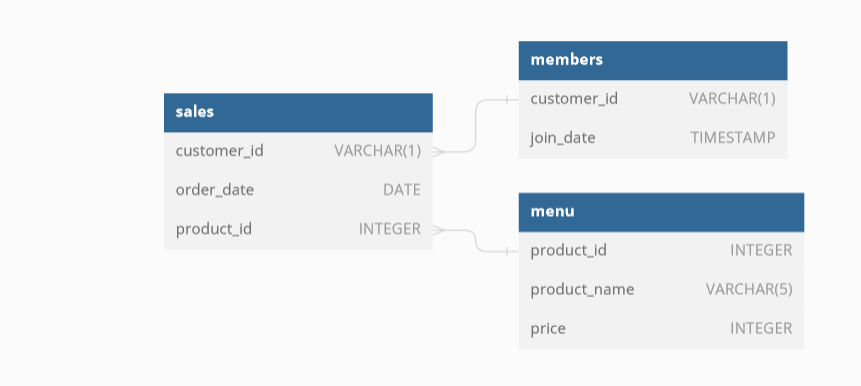

<h2> Case Study Questions </h2>
Each of the following case study questions can be answered using a single SQL statement:

1. What is the total amount each customer spent at the restaurant?
2. How many days has each customer visited the restaurant?
3. What was the first item from the menu purchased by each customer?
4. What is the most purchased item on the menu and how many times was it purchased by all customers?
5. Which item was the most popular for each customer?
6. Which item was purchased first by the customer after they became a member?
7. Which item was purchased just before the customer became a member?
8. What is the total items and amount spent for each member before they became a member?
9. If each $1 spent equates to 10 points and sushi has a 2x points multiplier - how many points would each customer have?
10. In the first week after a customer joins the program (including their join date) they earn 2x points on all items, not just sushi - how many points do customer A and B have at the end of January?

In [1]:
import pandas as pd

In [2]:
sales_file_path = 'Data/sales.csv'
menu_file_path = 'Data/menu.csv'
members_file_path = 'Data/members.csv'

In [3]:
df_sales = pd.read_csv(sales_file_path)
df_members = pd.read_csv(members_file_path)
df_menu = pd.read_csv(menu_file_path)

In [4]:
df_sales.head(5)

,customer_id,order_date,product_id
0,A,2021-01-01,1
1,A,2021-01-01,2
2,A,2021-01-07,2
3,A,2021-01-10,3
4,A,2021-01-11,3


In [5]:
df_members

,customer_id,join_date
0,A,2021-01-07
1,B,2021-01-09


In [6]:
df_menu

,product_id,product_name,price
0,1,sushi,10
1,2,curry,15
2,3,ramen,12


In [7]:
# What is the total amount each customer spent at the restaurant?

(df_sales
#  .join(df_menu, on='product_id', how='inner', lsuffix='_left', rsuffix='_right')
 .merge(df_menu, on='product_id', how='inner')
 .groupby('customer_id')
 .agg({'price': 'sum'})
 .reset_index()
)

,customer_id,price
0,A,76
1,B,74
2,C,36


In [8]:
# How many days has each customer visited the restaurant?

(df_sales
 .groupby('customer_id')
#  .agg({'order_date': 'nunique'})
 .agg(total_visits=('order_date', 'nunique'))
 .reset_index()
)

,customer_id,total_visits
0,A,4
1,B,6
2,C,2


In [9]:
# What was the first item from the menu purchased by each customer?

df = df_sales.copy()

df['rank'] = df.groupby(['customer_id'])['order_date'].rank(method='dense')

(df
 .where(df['rank'] == 1)
 .merge(df_menu, on='product_id', how='inner')
 .drop_duplicates()
 .loc[:,['customer_id', 'product_name', 'product_id']]
 .head()
)

,customer_id,product_name,product_id
0,A,sushi,1.0
1,A,curry,2.0
2,B,curry,2.0
3,C,ramen,3.0


In [10]:
# What is the most purchased item on the menu and how many times was it purchased by all customers?

(
  df_sales
    .merge(df_menu, on='product_id', how='inner')
    .groupby('product_name')
    .agg(total_purchase=('product_name','count'))
    .sort_values('total_purchase', ascending=False)
    .reset_index()
    .head(1)
)

,product_name,total_purchase
0,ramen,8


In [11]:
# Which item was the most popular for each customer?

df = (df_sales
      .groupby(['customer_id', 'product_id'])
      .agg(total_purchase=('product_id','count'))
      .reset_index()
      .copy()
     )

df['rank'] = (df
              .groupby('customer_id')['total_purchase']
              .rank(method='dense', ascending=False)
             )
(
    df[df['rank'] == 1]
    .merge(df_menu, on='product_id', how='inner')
    .loc[:,['customer_id', 'product_name']]
)

,customer_id,product_name
0,A,ramen
1,B,ramen
2,C,ramen
3,B,sushi
4,B,curry


In [12]:
# Which item was purchased first by the customer after they became a member?

from datetime import datetime

df = (df_sales
      .merge(df_menu, on='product_id', how='inner')
      .merge(df_members, on='customer_id', how='inner')
     )

df['order_date'] = df['order_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
df['join_date'] = df['join_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

df = (df[df['order_date'] >= df['join_date']].reset_index())

df['rank'] = (df
              .groupby('customer_id')['order_date']
              .rank(method='dense')
             )

(
    df[df['rank'] == 1]
      .loc[:, ['customer_id', 'product_name']]
)

,customer_id,product_name
0,A,curry
4,B,sushi


In [13]:
# Which item was purchased just before the customer became a member?

from datetime import datetime

df = (df_sales
      .merge(df_menu, on='product_id', how='inner')
      .merge(df_members, on='customer_id', how='inner')
     )

df['order_date'] = df['order_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
df['join_date'] = df['join_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

df = (df[df['order_date'] < df['join_date']].reset_index())

df['rank'] = (df
              .groupby('customer_id')['order_date']
              .rank(method='dense', ascending=False)
             )
(
    df[df['rank'] == 1]
      .loc[:, ['customer_id', 'product_name']]
)

,customer_id,product_name
0,A,sushi
1,A,curry
2,B,sushi


In [14]:
# What is the total items and amount spent for each member before they became a member?

from datetime import datetime

df = (df_sales
      .merge(df_menu, on='product_id', how='inner')
      .merge(df_members, on='customer_id', how='inner')
     )

df['order_date'] = df['order_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
df['join_date'] = df['join_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

(df[df['order_date'] < df['join_date']]
 .groupby('customer_id')[['product_id', 'price']]
 .agg(total_items=('product_id', 'count'),
      amount_spent=('price', 'sum')
     )
 .reset_index()
)


,customer_id,total_items,amount_spent
0,A,2,25
1,B,3,40


In [15]:
# If each $1 spent equates to 10 points and sushi has a 2x points multiplier - how many points would each customer have?

df = (df_sales
      .merge(df_menu, on='product_id', how='inner')
     )

df['prod_point'] = df['product_name'].apply(lambda prod_name: 20 if prod_name == 'sushi' else 10).astype(int)
df['points_mul'] = (df['prod_point'] * df['price']).astype(int)

(df
 .groupby('customer_id')[['points_mul']]
 .agg(total_points=('points_mul', 'sum'))
 .reset_index()
)

,customer_id,total_points
0,A,860
1,B,940
2,C,360


In [16]:
# In the first week after a customer joins the program (including their join date) they earn 2x points on all items,
# not just sushi - how many points do customer A and B have at the end of January?

from datetime import timedelta, datetime

def cal_price(ele: pd.core.series.Series) -> int:
    offer_date = ele['join_date'] + timedelta(days=6)
    if ele['product_name'] == 'sushi':
        return 2 * 10 * ele['price']
    elif ele['join_date'] <= ele['order_date']  <= offer_date:
        return 2 * 10 * ele['price']
    else:
        return 10 * ele['price']

df = (df_sales
      .merge(df_members, on='customer_id', how='inner')
      .merge(df_menu, on='product_id', how='inner')
     )

df['order_date'] = df['order_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
df['join_date'] = df['join_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

df = df[df.order_date.dt.strftime('%m') == '01']

df['total'] = df.apply(lambda x: cal_price(x), axis=1)

df.groupby(['customer_id'])['total'].sum()



customer_id
A    1370
B     820
Name: total, dtype: int64

In [17]:
# Join All the Things

import numpy as np

df = (df_sales
      .merge(df_members, on='customer_id', how='left')
      .merge(df_menu, on='product_id', how='inner')
     )

df['order_date'] = df['order_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
df['join_date'] = df['join_date'].apply(lambda x: None if x in (np.nan, np.NaN, None) else datetime.strptime(x, '%Y-%m-%d') )

df['member'] = df[['order_date', 'join_date']].apply(lambda x: 'Y' if x['order_date'] >= x['join_date'] else 'N', axis=1)
df.loc[:,['customer_id', 'order_date', 'product_name', 'price', 'member']]

,customer_id,order_date,product_name,price,member
0,A,2021-01-01,sushi,10,N
1,B,2021-01-04,sushi,10,N
2,B,2021-01-11,sushi,10,Y
3,A,2021-01-01,curry,15,N
4,A,2021-01-07,curry,15,Y
5,B,2021-01-01,curry,15,N
6,B,2021-01-02,curry,15,N
7,A,2021-01-10,ramen,12,Y
8,A,2021-01-11,ramen,12,Y
9,A,2021-01-11,ramen,12,Y


In [18]:
# Rank All the Things

import numpy as np

df = (df_sales
      .merge(df_members, on='customer_id', how='left')
      .merge(df_menu, on='product_id', how='inner')
     )

df['order_date'] = df['order_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
df['join_date'] = df['join_date'].apply(lambda x: None if x in (np.nan, np.NaN, None) else datetime.strptime(x, '%Y-%m-%d') )

df['member'] = df[['order_date', 'join_date']].apply(lambda x: 'Y' if x['order_date'] >= x['join_date'] else 'N', axis=1)
df['rank'] = df.groupby(['customer_id', 'member'])['order_date'].rank(method='dense', ascending=True)
df['rank'] = df[['member', 'rank']].apply(lambda x: np.NaN if x['member'] == 'N' else x['rank'], axis=1)

(df
 .loc[:,['customer_id', 'order_date', 'product_name', 'price', 'member', 'rank']]
 .sort_values(['customer_id', 'order_date'])
 .reset_index()
)

,index,customer_id,order_date,product_name,price,member,rank
0,0,A,2021-01-01,sushi,10,N,NaN
1,3,A,2021-01-01,curry,15,N,NaN
2,4,A,2021-01-07,curry,15,Y,1.0
3,7,A,2021-01-10,ramen,12,Y,2.0
4,8,A,2021-01-11,ramen,12,Y,3.0
5,9,A,2021-01-11,ramen,12,Y,3.0
6,5,B,2021-01-01,curry,15,N,NaN
7,6,B,2021-01-02,curry,15,N,NaN
8,1,B,2021-01-04,sushi,10,N,NaN
9,2,B,2021-01-11,sushi,10,Y,1.0
